In [1]:
# Data manipulation and analysis
import pandas as pd  
import numpy as np
import os
import swifter
from tqdm import tqdm

#==== Data visualization ==========
import matplotlib.pyplot as plt 
import seaborn as sns

#==== Regular expressions and string processing ====
import re
import string

#==== Model persistence ====
import pickle

#==== Suppress warnings for cleaner output ====
import warnings
warnings.filterwarnings('ignore')

# ==== NLP Libraries ====
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

# ==== Machine Learning Libraries ====
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
# Download essential NLTK resources (run once, comment out after first run)
nltk.download('punkt')       # sentence + word tokenizer models
nltk.download('punkt_tab')   # new in NLTK 3.9+, needed for word_tokenize
nltk.download('stopwords')   # for stopword removal
nltk.download('wordnet')     # for lemmatizer

In [3]:
# Set up plot aesthetics for better visuals
plt.style.use('ggplot')
sns.set(style='whitegrid')

In [4]:
def load_fasttext_data_sample(filepath, nrows=None):
    """
    Load FastText .ft.txt file.
    If nrows is provided, only read first nrows lines.
    """
    data = []
    with open(filepath, encoding='latin1') as f:
        for i, line in enumerate(f):
            if nrows is not None and i >= nrows:
                break
            label, text = line.strip().split(' ', 1)
            data.append([label, text])
    df = pd.DataFrame(data, columns=['label', 'text'])
    df['sentiment'] = df['label'].map({'__label__1': 'negative', '__label__2': 'positive'})
    return df   

In [5]:
# Load 5 lakhs rows for training
train_df = load_fasttext_data_sample('Data/train.ft.txt', nrows = 500000)
test_df = load_fasttext_data_sample('Data/test.ft.txt')  

print("🔹Successfully load the train and test data...")

print(train_df.shape) 
print(test_df.shape)

🔹Successfully load the train and test data...
(500000, 3)
(400000, 3)


In [6]:
train_df.head()

,label,text,sentiment
0,__label__2,Stuning even for the non-gamer: This sound tra...,positive
1,__label__2,The best soundtrack ever to anything.: I'm rea...,positive
2,__label__2,Amazing!: This soundtrack is my favorite music...,positive
3,__label__2,Excellent Soundtrack: I truly like this soundt...,positive
4,__label__2,"Remember, Pull Your Jaw Off The Floor After He...",positive


In [7]:
print(train_df[train_df['label'] == '__label__1'].head(2))

         label                                               text sentiment
6   __label__1  Buyer beware: This is a self-published book, a...  negative
10  __label__1  The Worst!: A complete waste of time. Typograp...  negative


In [ ]:
print(test_df[train_df['label'] == '__label__1'].head(2))

In [10]:
print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

Training data shape: (500000, 3)
Test data shape: (400000, 3)


In [ ]:
print("\nMissing values in test data:")
print(test_df.isnull().sum())

In [13]:
print("\nSentiment distribution in training data:")
print(train_df['sentiment'].value_counts())


Sentiment distribution in training data:
sentiment
positive    252782
negative    247218
Name: count, dtype: int64


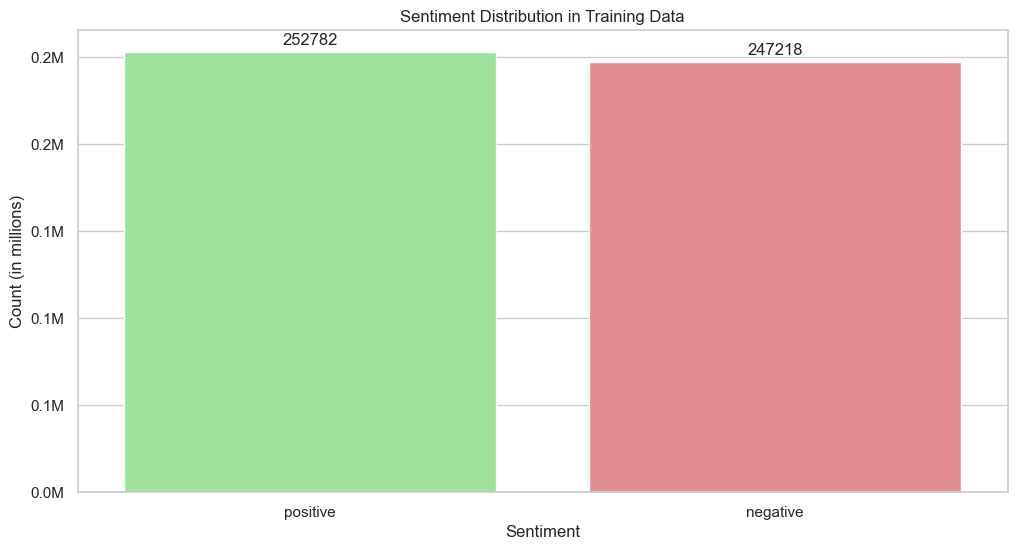

In [14]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    x='sentiment',
    data=train_df,
    palette={'negative': 'lightcoral', 'positive': 'lightgreen'}
)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

# Format y-axis to show millions
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1_000_000:.1f}M'))

plt.title('Sentiment Distribution in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count (in millions)')
plt.show()

In [15]:
# Convert 'text' to string to avoid errors with NaN (float) values
train_df['text'] = train_df['text'].astype(str)
test_df['text'] = test_df['text'].astype(str)

In [16]:
# Explore text length distribution
train_df['text_length'] = train_df['text'].apply(len)

<em>***Text length***: Text length is simply the number of characters or words in a piece of text. In NLP</em>

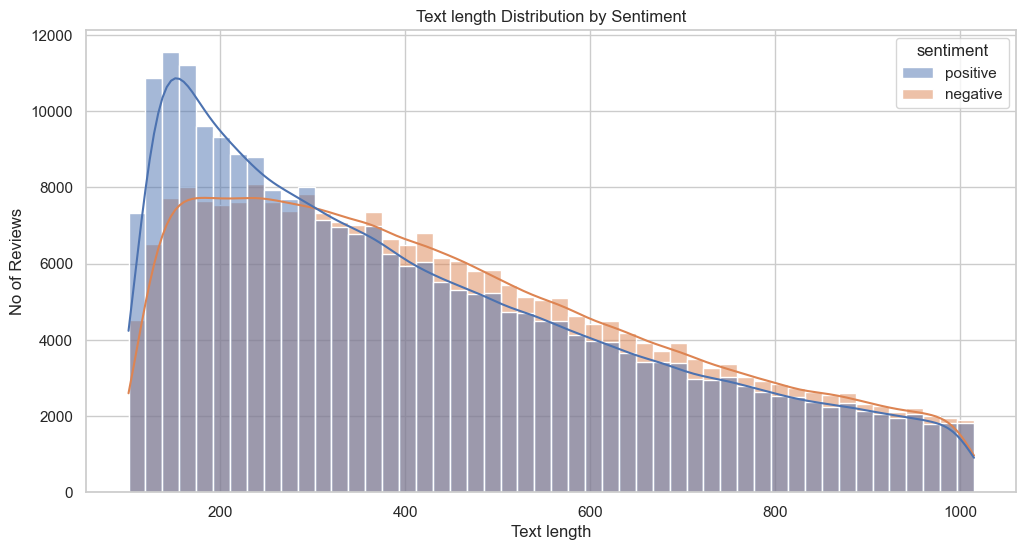

In [17]:
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x = 'text_length', hue='sentiment', bins=50, kde=True) 
plt.title('Text length Distribution by Sentiment')
plt.xlabel('Text length')
plt.ylabel('No of Reviews')
plt.show()

<h3><em>Text preprocessing</em></h3>

In [18]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
HTML_RE = re.compile(r'<.*?>')
DIGIT_RE = re.compile(r'\d+')

In [33]:
def preprocess_text(text):
    if not isinstance(text, str):
        return []

    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    text = text.lower()  # lowercase
    text = re.sub(r'\d+', '', text)  # remove numbers

    # Tokenize using NLTK
    tokens = word_tokenize(text)

    # Keep only alphabetic tokens and remove stopwords
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

print("🔹 Preprocessing train and test data using nltk...")

🔹 Preprocessing train and test data using nltk...


In [22]:
# Parallel preprocessing with swifter
print("🔹 Preprocessing train and test data...")

train_df["tokens"] = train_df["text"].swifter.apply(preprocess_text)

🔹 Preprocessing train and test data...


Pandas Apply:   0%|          | 0/500000 [00:00<?, ?it/s]

In [23]:
test_df["tokens"]  = test_df["text"].swifter.apply(preprocess_text)

Pandas Apply:   0%|          | 0/400000 [00:00<?, ?it/s]

In [25]:
import gc

gc.collect()

83301

In [26]:
all_tokens = pd.concat([train_df["tokens"], test_df["tokens"]], ignore_index=True)

In [27]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(
    sentences = all_tokens,   # List of tokenized sentences
    vector_size = 100,         # Dimensionality of embeddings
    window = 5,                # Context window size
    min_count = 5,             # Ignores words with frequency < 5
    sg = 1,                    # Use skip-gram (sg=0 → CBOW)
    workers = 6,               # Number of CPU cores to use
    hs = 0,                    # Hierarchical softmax disabled
    negative = 5               # Use negative sampling with 5 samples
)

w2v_model.save("word2vec_model.model") 
print(" Word2Vec model trained & saved")

 Word2Vec model trained & saved


In [29]:
# Extract vocabulary
vocab_set = set(w2v_model.wv.index_to_key)

def filter_tokens(tokens, vocab):
    if not isinstance(tokens, list):
        return []
    return [w for w in tokens if w in vocab]

In [31]:
all_tokens = all_tokens.swifter.apply(lambda x: filter_tokens(x, vocab_set))

Pandas Apply:   0%|          | 0/900000 [00:00<?, ?it/s]

In [35]:
# Fit TF-IDF
all_texts = all_tokens.swifter.apply(lambda x: " ".join(x)) # Convert list of tokens → space-separated string

tfidf = TfidfVectorizer(min_df=2)
tfidf.fit(all_texts)  # now it works
word2weight = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

# Weighted document vector
def document_vector_weighted(tokens, w2v_model, word2weight):
    vectors = []
    weights = []
    for word in tokens:
        if word in w2v_model.wv and word in word2weight:
            vectors.append(w2v_model.wv[word])
            weights.append(word2weight[word])
    if vectors:
        return np.average(vectors, axis=0, weights=weights)
    else:
        return np.zeros(w2v_model.vector_size, dtype=np.float32)

Pandas Apply:   0%|          | 0/900000 [00:00<?, ?it/s]

In [36]:
# Convert all reviews to weighted vectors
amazon_vectors = np.vstack(
    all_tokens.swifter.apply(lambda x: document_vector_weighted(x, w2v_model, word2weight))
)

Pandas Apply:   0%|          | 0/900000 [00:00<?, ?it/s]

In [38]:
print("Vector shape:", amazon_vectors.shape)

Vector shape: (900000, 100)


<h3><em>Ready for ML</em></h3>

In [43]:
print("\nSentiment distribution in training data:")
print(train_df['sentiment'].value_counts())


Sentiment distribution in training data:
sentiment
positive    252782
negative    247218
Name: count, dtype: int64


In [44]:
train_df["sentiment"] = train_df["sentiment"].map({"positive": 1, "negative": 0})

In [45]:
test_df["sentiment"] = test_df["sentiment"].map({"positive": 1, "negative": 0})

In [47]:
train_vectors = np.vstack(train_df['tokens'].swifter.apply(lambda x: document_vector_weighted(x, w2v_model, word2weight)))

Pandas Apply:   0%|          | 0/500000 [00:00<?, ?it/s]

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    train_vectors,
    train_df["sentiment"],
    test_size=0.2,
    stratify=train_df["sentiment"],
    random_state=42
)

In [50]:
from sklearn.linear_model import LogisticRegressionCV

lr_model = LogisticRegressionCV(
    Cs=10,                # number of C values to test
    cv=5,                 # 5-fold cross-validation
    penalty='l2',         # standard L2 regularization
    solver='liblinear',   # good for small/medium datasets
    scoring='f1',         # optimizes based on F1-score instead of accuracy
    max_iter=1000,
    n_jobs=-1,            # use all CPU cores for speed
    refit=True
)

In [51]:
lr_model.fit(X_train, y_train)

LogisticRegressionCV(cv=5, max_iter=1000, n_jobs=-1, scoring='f1',
                     solver='liblinear')

In [52]:
y_predd = lr_model.predict(X_test)

Accuracy: 85.74%

Confusion Matrix:
 [[42118  7326]
 [ 6935 43621]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.86     49444
           1       0.86      0.86      0.86     50556

    accuracy                           0.86    100000
   macro avg       0.86      0.86      0.86    100000
weighted avg       0.86      0.86      0.86    100000



Text(0.5, 1.0, 'Confusion Matrix')

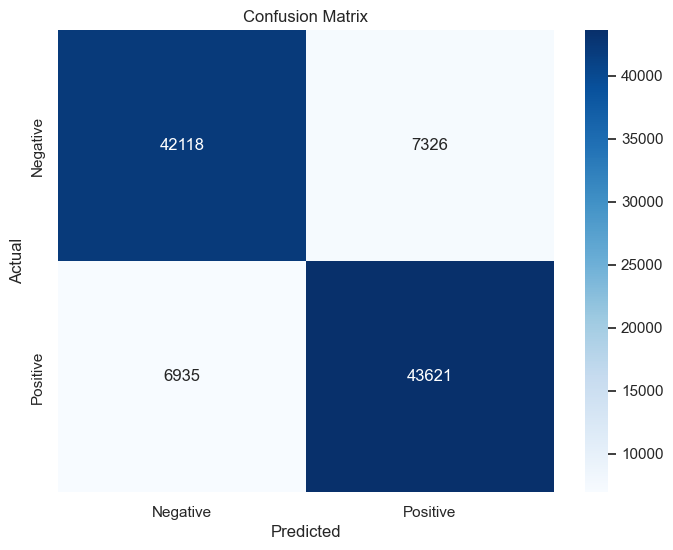

In [65]:
accuracy = accuracy_score(y_test, y_predd)
print(f"Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(y_test, y_predd)
print("\nConfusion Matrix:\n", cm)

cr = classification_report(y_test, y_predd)
print("\nClassification Report:\n", cr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix')

In [54]:
import joblib

best_model = lr_model
joblib.dump(best_model, "final_model.pkl")

print("Model saved successfully as 'final_model.pkl'")

Model saved successfully as 'final_model.pkl'


In [55]:
joblib.dump(tfidf, 'tfidf.pkl')
print("tfidf.pkl saved successfully as 'tfidf.pkl'")

tfidf.pkl saved successfully as 'tfidf.pkl'


In [56]:
user_review = input("Enter your review: ")

tokens = preprocess_text(user_review)
vector = document_vector_weighted(tokens, w2v_model, word2weight).reshape(1, -1)

prediction = lr_model.predict(vector)

print("Positive" if prediction[0] == 1 else "Negative")

Enter your review:  Buyer beware: This is a self-published book


Negative


<h3><em>Garbage Collection Note</em></h3>

Python automatically frees memory for objects that are no longer referenced,  
but with **very large datasets** (millions of rows) or **big embeddings**,  
temporary objects like intermediate DataFrames or arrays may linger in RAM.

<h4><em>🔹 Why explicitly use `gc.collect()`</em></h4>

1. Immediately frees memory of unused objects.  
2. Helps prevent **MemoryErrors** or slowdowns during memory-heavy operations,  
   e.g., Word2Vec training or stacking large NumPy arrays.  
3. Especially useful on RAM-constrained machines (like an **8 GB laptop**).

**Tip:** Call `gc.collect()` after major intermediate steps to keep memory usage low.

In [1]:
import nbformat
from nbconvert import HTMLExporter

with open("notebook.ipynb", "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

# Create an HTML exporter
html_exporter = HTMLExporter()
html_exporter.template_name = "classic"  # or "lab", "reveal", etc.

# Convert the notebook to HTML
body, resources = html_exporter.from_notebook_node(nb)

# Save the HTML output
output_file = "NLP_Pipeline_ModelBuilding.html"
with open(output_file, "w", encoding="utf-8") as f:
    f.write(body)

print(f"Notebook successfully converted to HTML: {output_file}")

Notebook successfully converted to HTML: NLP_Pipeline_ModelBuilding.html
